# BetterWrapped

## Setup

### Importing libraries

In [2]:
import pandas as pd
import numpy as np
import os
import time
import pycountry

### Loading API-Keys

In [3]:
from dotenv import load_dotenv
load_dotenv()

True

### Defining colorscheme

In [4]:
GREY_SCALE = ["#000000",
              "#1a1a1a",
              "#333333",
              "#4d4d4d",
              "#666666",
              "#7f7f7f",
              "#999999",
              "#B3B3B3",
              "#CCCCCC",
              "#E6E6E6",
              "#FFFFFF"]

RETRO_SCALE = ["#360185",
               "#8F0177",
               "#DE1A58",
               "#F4B342",
               "#6DC3BB",
               "#F2AEBB",
               "#E83C91"]

COLOR_SCALE_10 = ["#1b9e77",
                  "#d95f02",
                  "#7570b3",
                  "#e7298a",
                  "#66a61e",
                  "#e6ab02",
                  "#a6761d",
                  "#666666",
                  "#1f78b4",
                  "#b2df8a"]

## Importing Spotify data

### Reading data

In [5]:
df_raw = pd.DataFrame()
for file in [x for x in os.listdir("Spotify Extended Streaming History") if x.startswith("Streaming_History_Audio")]:
    df_raw = pd.concat([df_raw, pd.read_json("Spotify Extended Streaming History/"+file)])
df_raw.sample(3)

,ts,platform,ms_played,conn_country,ip_addr,master_metadata_track_name,master_metadata_album_artist_name,master_metadata_album_album_name,spotify_track_uri,episode_name,...,audiobook_uri,audiobook_chapter_uri,audiobook_chapter_title,reason_start,reason_end,shuffle,skipped,offline,offline_timestamp,incognito_mode
5032,2019-11-23T19:38:24Z,"Android OS 9 API 28 (Xiaomi, Mi A3)",902,CH,83.78.245.27,Mensch si,Gimma,Mensch Si,spotify:track:1ts0DFiyWg9aByQVsJ5h3K,None,...,NaN,NaN,NaN,clickrow,endplay,False,False,False,NaN,False
12594,2020-10-26T06:06:10Z,"Android OS 10 API 29 (Xiaomi, Mi A3)",1271,CH,194.230.147.4,I'm a Mess,Bebe Rexha,Expectations,spotify:track:04ZTP5KsCypmtCmQg5tH9R,None,...,NaN,NaN,NaN,fwdbtn,fwdbtn,False,False,False,NaN,False
1051,2023-10-14T22:07:16Z,ios,2385,CH,194.230.160.15,IDGAF (with blackbear),BoyWithUke,IDGAF,spotify:track:6Jrdb6CFOJEGaHjaa6c4WR,None,...,NaN,NaN,NaN,trackdone,fwdbtn,True,True,False,1.697321e+09,False


### Formatting and cleaning data

In [6]:
df = df_raw.drop(columns=["episode_name", "episode_show_name", "spotify_episode_uri", "audiobook_title", "audiobook_uri", "audiobook_chapter_uri", "audiobook_chapter_title"])
df.rename(columns={"conn_country":"country_code", "ip_addr":"ip", "master_metadata_track_name":"track_name", "master_metadata_album_artist_name":"artist_name", "master_metadata_album_album_name":"album_name"}, inplace=True)
df["ts"] = pd.to_datetime(df["ts"])
df["ts"] = df["ts"].dt.tz_localize(None)
df = df.dropna(subset=["artist_name"])
df["s_played"] = df["ms_played"]/1000
df["min_played"] = df["s_played"]/60
df["h_played"] = df["min_played"]/60
df["d_played"] = df["h_played"]/24
df["country_name"] = df["country_code"].map(lambda x : pycountry.countries.get(alpha_2=x).name if pycountry.countries.get(alpha_2=x) else "Unbekannt")
df["date"] = df["ts"].dt.date
df["year"] = df["ts"].dt.year
df["month"] = df["ts"].dt.month
df["day"] = df["ts"].dt.day
df["time"] = df["ts"].dt.time
df["hour"] = df["ts"].dt.hour
df["minute"] = df["ts"].dt.minute
df["second"] = df["ts"].dt.second
df["spotify_track_uri"] = df["spotify_track_uri"].str.split(':').str[-1]
df.sample(3)

,ts,platform,ms_played,country_code,ip,track_name,artist_name,album_name,spotify_track_uri,reason_start,...,d_played,country_name,date,year,month,day,time,hour,minute,second
4851,2022-11-23 20:35:24,android,1910,CH,194.230.160.82,Survivor,Die Happy,Red Box,0ZVBS0Oe0oAdCyVr4Gfhhl,clickrow,...,0.000022,Switzerland,2022-11-23,2022,11,23,20:35:24,20,35,24
13657,2023-07-11 12:01:52,tizen,49450,CH,84.72.9.181,Call Me Maybe,Carly Rae Jepsen,Kiss,20I6sIOMTCkB6w7ryavxtO,fwdbtn,...,0.000572,Switzerland,2023-07-11,2023,7,11,12:01:52,12,1,52
8943,2021-10-13 16:02:53,"Android OS 9 API 28 (LGE, LG-H870)",223716,CH,194.230.147.84,Someday,Kygo,Golden Hour,73h6Ma5QhBFrshEN2CTevS,fwdbtn,...,0.002589,Switzerland,2021-10-13,2021,10,13,16:02:53,16,2,53


## Fetching data

In [7]:
import requests

In [8]:
if not "fetched_data" in os.listdir():
    os.mkdir("fetched_data")

### Fetching genres

https://developer.spotify.com/

In [9]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy.client import SpotifyException

In [10]:
CLIENT_ID = os.getenv("CLIENT_ID")
CLIENT_SECRET = os.getenv("CLIENT_SECRET")

In [11]:
auth_manager = SpotifyClientCredentials(client_id=CLIENT_ID, client_secret=CLIENT_SECRET)
sp = spotipy.Spotify(auth_manager=auth_manager)

In [12]:
def fetch_artist_genre(sp, artist, max_retries=5, initial_wait=5):
    tries = 0
    wait = initial_wait
    while tries < max_retries:
        try:
            genre = sp.search(q=artist, type="artist")["artists"]["items"][0]["genres"]
            return genre
        except (requests.exceptions.ReadTimeout, SpotifyException):
            time.sleep(wait)
            wait *= 2
            tries += 1
    return []

In [13]:
if not "artist_genre.csv" in os.listdir("fetched_data"):
    artists = df["artist_name"].unique()
    list_artist_genre = [[artist, fetch_artist_genre(sp, artist)] for artist in artists]
    list_artist_genre = [[artist, ", ".join(genres)] for artist, genres in list_artist_genre]
    df_artist_genre = pd.DataFrame(list_artist_genre, columns=["artist_name", "genre"])
    df_artist_genre.to_csv("fetched_data/artist_genre.csv", index=False)
else:
    df_artist_genre = pd.read_csv("fetched_data/artist_genre.csv")

In [14]:
df = df.merge(df_artist_genre, on="artist_name", how="left")

### Fetching IP geolocation

https://github.com/ipinfo/python?tab=readme-ov-file#lite-api
https://ipinfo.io

In [15]:
import ipinfo

In [16]:
access_token = os.getenv("access_token")

In [17]:
handler = ipinfo.getHandler(access_token)

In [18]:
def fetch_ip_loc(handler, ip, max_retries=5, initial_wait=5, timeout=10):
    tries = 0
    wait = initial_wait
    while tries < max_retries:
        try:
            details = handler.getDetails(ip, timeout)
            return details
        except (requests.exceptions.ReadTimeout):
            time.sleep(wait)
            wait *= 2
            tries += 1
    return []

In [19]:
if not "ip_loc.csv" in os.listdir("fetched_data"):
    list_ip_loc = [[ip, fetch_ip_loc(handler, ip).loc, fetch_ip_loc(handler, ip).city, fetch_ip_loc(handler, ip).region] for ip in df["ip"].unique()]
    df_ip_loc = pd.DataFrame(list_ip_loc, columns=["ip", "geo_loc", "city_name", "region_name"])
    df_ip_loc.to_csv("fetched_data/ip_loc.csv", index=False)
else:
    df_ip_loc = pd.read_csv("fetched_data/ip_loc.csv")

In [20]:
df = df.merge(df_ip_loc, on="ip", how="left")

In [21]:
df[["lat", "lon"]] = df["geo_loc"].str.split(",", expand=True)
df["lat"] = df["lat"].astype(float)
df["lon"] = df["lon"].astype(float)

### Fetching track infos (Paid)

https://rapidapi.com/soundnet-soundnet-default/api/track-analysis/

In [22]:
from concurrent.futures import ThreadPoolExecutor
import requests

In [23]:
API_KEY = os.getenv("API_KEY")

In [24]:
url = "https://track-analysis.p.rapidapi.com/pktx/analysis"

headers = {
	"x-rapidapi-key": API_KEY,
	"x-rapidapi-host": "track-analysis.p.rapidapi.com"
}

In [25]:
def fetch(track):
    querystring  = {"song": track}
    response = requests.get(url, headers=headers, params=querystring).json()
    response["track_name"] = track
    return response

df_failed_track = pd.DataFrame()
if not "track_info.csv" in os.listdir("fetched_data"):
    with ThreadPoolExecutor(max_workers=10) as executor:
        results = executor.map(fetch, df["track_name"].unique()[:100])

    df_track_info = pd.DataFrame(results)
    df_failed_track = df_track_info[df_track_info["key"].isna()]["track_name"]
    df_track_info = df_track_info[~df_track_info["key"].isna()]
    try:
        df_track_info.drop(columns=["album", "name", "error", "messages", "info"], inplace=True)
    except:
        pass
    df_track_info["loudness"] = df_track_info["loudness"].str.replace(" dB", "", regex=False).astype(int)
    df_track_info["s_duration"] = df_track_info["duration"].str.split(":").apply(lambda x: int(x[0])*60 + int(x[1]))
    df_track_info = df_track_info.drop(columns=["duration", "id"])
    df_track_info.to_csv("fetched_data/track_info.csv", index=False)
else:
    df_track_info = pd.read_csv("fetched_data/track_info.csv")

In [26]:
df = df.merge(df_track_info, on="track_name", how="left")

## Explaining data

### Quick overview

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85534 entries, 0 to 85533
Data columns (total 49 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   ts                 85534 non-null  datetime64[ns]
 1   platform           85534 non-null  object        
 2   ms_played          85534 non-null  int64         
 3   country_code       85534 non-null  object        
 4   ip                 85534 non-null  object        
 5   track_name         85534 non-null  object        
 6   artist_name        85534 non-null  object        
 7   album_name         85534 non-null  object        
 8   spotify_track_uri  85534 non-null  object        
 9   reason_start       85534 non-null  object        
 10  reason_end         85534 non-null  object        
 11  shuffle            85534 non-null  bool          
 12  skipped            85534 non-null  bool          
 13  offline            85534 non-null  bool          
 14  offlin

### Detailed description

| Attribute | Description |
|-----------|-------------|
| ts | This field is a timestamp indicating when the track stopped playing in UTC (Coordinated Universal Time). The order is year, month and day followed by a timestamp in military time |
| platform | This field is the platform used when streaming the track (e.g. Android OS, Google Chromecast). |
| ms_played | This field is the number of milliseconds the stream was played. |
| country_code | This field is the country code of the country where the stream was played (e.g. SE - Sweden). |
| ip | This field contains the IP address logged when streaming the track. |
| track_name | This field is the name of the track. |
| artist_name | This field is the name of the artist, band or podcast. |
| album_name | This field is the name of the album of the track. |
| spotify_track_uri  | A Spotify URI, uniquely identifying the track in the form of “spotify:track:<base-62 string>” <br><br> A Spotify URI is a resource identifier that you can enter, for example, in the Spotify Desktop client’s search box to locate an artist, album, or track. |
| reason_start | This field is a value telling why the track started (e.g. “trackdone”) |
| reason_end | This field is a value telling why the track ended (e.g. “endplay”). |
| shuffle | This field has the value True or False depending on if shuffle mode was used when playing the track. |
| skipped | This field indicates if the user skipped to the next song |
| offline | This field indicates whether the track was played in offline mode (“True”) or not (“False”). |
| offline_timestamp | This field is a timestamp of when offline mode was used, if used. |
| incognito_mode | This field indicates whether the track was played during a private session (“True”) or not (“False”). |
| s_played | This field is the number of seconds the stream was played.|
| min_played | This field is the number of minutes the stream was played.|
| h_played | This field is the number of hours the stream was played.|
| d_played | This field is the number of days the stream was played.|
| country_name | This field is the country name of the country where the stream was played (e.g. Sweden - SE).|
| date | This field contains the date extracted from ts |
| year | This field contains the year extracted from ts |
| month | This field contains the month extracted from ts |
| day | This field contains the day extracted from ts |
| time | This field contains the time extracted from ts |
| hour | This field contains the hour extracted from ts |
| minute | This field contains the minute extracted from ts |
| second | This field contains the second extracted from ts |
| genre | This field is the genre of the artist |
| geo_loc | This field is the location coordinates in the format (latitude,longitude) where the stream was played. |
| city_name | This field is the city name of the city where the stream was played. |
| region_name | This field is the region name of the region where the stream was played. |
| lat | This field is the latitudinal location coordinates from where the stream was played. |
| lon | This field is the longitudinal location coordinates from where the stream was played. |
| key | This field represents the musical key of the track, indicating the pitch class (e.g., C, C♯/D♭, D, … B♭). It corresponds to the tonal center around which the music is built. |
| mode | This field indicates whether the track is composed in a major or minor scale. “Major” typically conveys a brighter sound, while “minor” tends to be darker or more somber. |
| camelot | This field is the Camelot Wheel notation of the musical key (e.g., 6B, 8A). It is used by DJs to easily identify compatible keys for harmonic mixing. |
| tempo | This field is the estimated overall tempo of the track measured in beats per minute (BPM). It reflects the speed or pace of the music. |
| popularity | This field is a score between 0 and 100 indicating how popular the track is, based on total plays and how recent those plays are. |
| energy | This field is a value describing the intensity and activity level of the track. Higher values indicate faster, louder, and more dynamic music. |
| danceability | This field describes how suitable the track is for dancing. It is based on tempo, beat strength, rhythm stability, and overall musical regularity. |
| happiness | This field (also known as valence) describes how positive or cheerful the musical track sounds. Higher values correspond to happier, brighter, or more uplifting music. |
| acousticness | This field measures how acoustic a track is, with higher values indicating a greater likelihood that the track contains primarily acoustic instrumentation. |
| instrumentalness | This field predicts whether a track contains no vocals. Higher values indicate a greater probability that the track is instrumental, although sounds like “oohs” or “aahs” may still be present. |
| liveness | This field indicates the likelihood that the track was recorded with a live audience. Higher values suggest that the track may be from a live performance. |
| speechiness | This field describes the presence of spoken words in the track. Higher values indicate more speech-like audio content, such as talk shows, poetry, or rap. |
| loudness | This field represents the average loudness of the track in decibels (dB). It allows comparisons of overall volume across different tracks. |
| s_duration | This field is the total duration of the track in seconds. |

### Translation from attributes to displayable names

In [28]:
dict_att_disp = {
    "artist_name":"Artist",
    "track_name":"Track",
    "genre":"Genre",
    "album_name":"Album",
    "country_name":"Country",
    "region_name":"Region",
    "city_name":"City",
    "platform":"Platform",
    "ms_played":"Milliseconds",
    "s_played":"Seconds",
    "min_played":"Minutes",
    "h_played":"Hours",
    "d_played":"Days"
}

In [29]:
dict_time_disp = {
    "count":"",
    "ms_played":"ms",
    "s_played":"s",
    "min_played":"min",
    "h_played":"h",
    "d_played":"d"
}

## Exploring data

In [30]:
import matplotlib.pyplot as plt

In [31]:
def time_scope(date):
    if date == "first":
        return pd.to_datetime(df["ts"].min())
    elif date == "last":
        return pd.to_datetime(df["ts"].max())
    else:
        return pd.to_datetime(date)

### Exploring static data

#### Your Spotify usage

In [32]:
print("You started using Spotify in", df["ts"].min().date())
print("You listened to ", df.shape[0], " tracks, over the course of ", (df["ts"].max() - df["ts"].min()).days, " days (", round((df["ts"].max() - df["ts"].min()).days/365, 2), " years)", sep="")
print("You listened to Spotify for ", df["ms_played"].sum()//3600000, " hours (", df["ms_played"].sum()//3600000//24, " days)", sep="")

You started using Spotify in 2018-11-12
You listened to 85534 tracks, over the course of 2542 days (6.96 years)
You listened to Spotify for 2567 hours (106 days)


#### Your "favourites"

In [33]:
def get_top_data(attribute, sorting_value, time_format, top_count, start, end):
    if sorting_value == "track_count":
        if attribute == "genre":
            return (df[(df["ts"] > start) & (df["ts"] < end)][attribute].str.split(", ").explode().value_counts()[:top_count].reset_index())
        else:
            return df[(df["ts"] > start) & (df["ts"] < end)][attribute].value_counts()[:top_count].reset_index()
    elif sorting_value == "listening_time":
        if attribute == "genre":
            return df[(df["ts"] > start) & (df["ts"] < end)][[attribute, time_format]].assign(genre=df[attribute].str.split(", ")).explode(attribute).groupby(attribute)[time_format].sum().sort_values(ascending=False)[:top_count].reset_index().round(1)
        else:
            return df[(df["ts"] > start) & (df["ts"] < end)][[attribute, time_format]].groupby(attribute).sum().sort_values(time_format, ascending=False)[:top_count].reset_index().round(1)

In [34]:
def bar_plot(categories, values, start, end, title="Bar Chart", x_label="Categories", y_label="Values"):
    fig, ax = plt.subplots(figsize=(7, 4))
    x_pos = np.arange(len(categories))
    bar_artists = ax.bar(x_pos, values, color="#4C72B0", edgecolor="black")

    ax.set_title(f"{title}\nfrom {start.date()} to {end.date()}")
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(categories)

    for bar in bar_artists:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height,
            f"{height:.1f}",
            ha="center",
            va="bottom"
        )

    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
    ax.grid(axis="y", linestyle="--", alpha=0.5)

    plt.show()
    return

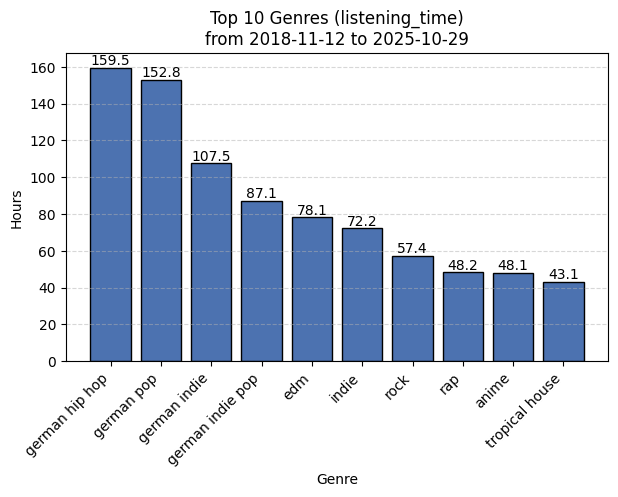

In [35]:
attribute = "genre" #artist_name, track_name, genre, album_name, country_name, region_name, city_name or platform
top_count = 10 #the top n will be returned
sorting_value = "listening_time" #track_count or listening_time
time_format = "h_played" #ms_played, s_played, min_played, h_played, d_played
start = time_scope("first") #"year-month-day" or "first"
end = time_scope("last") #"year-month-day" or "last"

x = get_top_data(attribute, sorting_value, time_format, top_count, start, end)[attribute]
y = get_top_data(attribute, sorting_value, time_format, top_count, start, end).iloc[:,-1]
bar_plot(x, y, start, end, f"Top {top_count} {dict_att_disp[attribute]}s ({sorting_value})", dict_att_disp[attribute], dict_att_disp[time_format])

### Exploring dynamic data

In [36]:
month_names = {1: "January",
               2: "February",
               3: "March",
               4: "April",
               5: "May",
               6: "June",
               7: "July",
               8: "August",
               9: "September",
               10: "October",
               11: "November",
               12: "December"
}

In [37]:
weekday_names = {0: "Monday",
                 1: "Tuesday",
                 2: "Wednesday",
                 3: "Thursday",
                 4: "Friday",
                 5: "Saturday",
                 6: "Sunday"
}

#### Filtered items over time

In [38]:
def scatter_plot(x_values, y_values, start, end, title="Scatter Plot", x_label="X", y_label="Y"):
    fig, ax = plt.subplots(figsize=(7, 4))

    ax.scatter(x_values, y_values, color="#4C72B0", edgecolor="black")

    ax.set_title(f"{title}\nfrom {start.date()} to {end.date()}")
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)

    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

    ax.grid(linestyle="--", alpha=0.5)

    plt.show()
    return

In [39]:
def plot(x_values, y_values, start, end, title="Scatter Plot", x_label="X", y_label="Y"):
    fig, ax = plt.subplots(figsize=(7, 4))

    ax.plot(x_values, y_values, linestyle="-", marker="o", color="#4C72B0")

    ax.set_title(f"{title}\nfrom {start.date()} to {end.date()}")
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)

    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

    ax.grid(linestyle="--", alpha=0.5)

    plt.show()
    return

In [40]:
def get_listening_dates_counted(attribute, item, measuring_value, start, end, format):
    if item == ["all"]:
        df_filtered_item = df[(df["ts"] > start) & (df["ts"] < end)][[attribute, "date", "ms_played", "s_played", "min_played", "h_played", "d_played"]]
    elif attribute == "genre":
        df_filtered_item = df[(df["ts"] > start) & (df["ts"] < end) & (df[attribute].fillna("").str.split(r",\s*").apply(lambda genres: any(target == g for g in genres for target in item)))][[attribute, "date", "ms_played", "s_played", "min_played", "h_played", "d_played"]]
    else:
        df_filtered_item = df[(df["ts"] > start) & (df["ts"] < end) & (df[attribute].isin(item))][[attribute, "date", "ms_played", "s_played", "min_played", "h_played", "d_played"]]
    
    df_dates_item_listening_time = df_filtered_item.groupby("date")[["ms_played", "s_played", "min_played", "h_played", "d_played"]].sum().reset_index()
    df_dates_item_track_count = df_filtered_item.groupby("date").value_counts().groupby("date").sum().reset_index()
    df_dates_item = df_dates_item_listening_time.merge(df_dates_item_track_count, on="date")
    df_dates_item["date"] = pd.to_datetime(df_dates_item["date"])

    rng_dates_filled = pd.date_range(start=start, end=end, freq="d")
    df_dates_filled = pd.DataFrame(rng_dates_filled)
    df_dates_filled.columns = ["date"]
    df_dates_item_filled = df_dates_filled.merge(df_dates_item, on="date", how="outer").sort_values("date").fillna(0)

    divisor_month = time_scope("last").year - time_scope("first").year
    divisor_weekday = divisor_month*52

    if format == "average_weekday":
        listening_dates_counted_average_weekday = (df_dates_item_filled.groupby(df_dates_item_filled["date"].dt.weekday)[measuring_value].sum()/divisor_weekday).reset_index()
        listening_dates_counted_average_weekday["date"] = listening_dates_counted_average_weekday["date"].map(weekday_names)
        return listening_dates_counted_average_weekday
    elif format == "average_month":
        listening_dates_counted_average_month = (df_dates_item_filled.groupby(df_dates_item_filled["date"].dt.month)[measuring_value].sum()/divisor_month).reset_index()
        listening_dates_counted_average_month["date"] = listening_dates_counted_average_month["date"].map(month_names)
        return listening_dates_counted_average_month
    elif format == "day":
        return df_dates_item_filled[["date", measuring_value]]
    elif format == "month":
        df_dates_item_filled_month = df_dates_item_filled.groupby(df_dates_item_filled["date"].dt.to_period("M"))[measuring_value].sum().reset_index()
        df_dates_item_filled_month["date"] = pd.to_datetime(df_dates_item_filled_month["date"].astype(str))
        return df_dates_item_filled_month
    elif format == "year":
        df_dates_item_filled_year = df_dates_item_filled.groupby(df_dates_item_filled["date"].dt.year)[measuring_value].sum().reset_index()
        return df_dates_item_filled_year

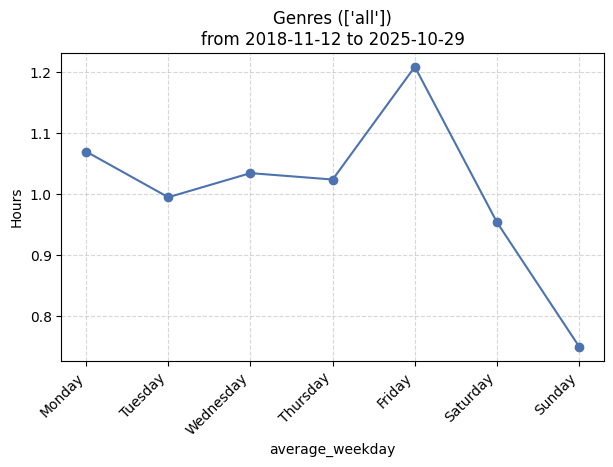

In [41]:
attribute = "genre" #artist_name, track_name, genre, album_name, country_name, region_name, city_name or platform
item = ["all"] #enter an item (or items) contained in attribute, in the form of a list. Or ["all"] for the whole df
measuring_value = "h_played" #count, ms_played, s_played, min_played, h_played, d_played
start = time_scope("first") #"year-month-day" or "first"
end = time_scope("last") #"year-month-day" or "last"
format = "average_weekday" #average_weekday, average_month, day, month, year

x = get_listening_dates_counted(attribute, item, measuring_value, start, end, format)["date"]
y = get_listening_dates_counted(attribute, item, measuring_value, start, end, format)[measuring_value]
plot(x, y, start, end, f"{dict_att_disp[attribute]}s ({item})", format, dict_att_disp[measuring_value])

## Understanding data

### Listening Time of attribute

In [47]:
attribute = "genre" #artist_name, track_name, genre, album_name, country_name, region_name, city_name or platform
top_count = 7 #the top n will be returned
sorting_value = "listening_time" #track_count or listening_time
time_format = "h_played" #ms_played, s_played, min_played, h_played, d_played
start = time_scope("first") #"year-month-day" or "first"
end = time_scope("last") #"year-month-day" or "last"

measuring_value = "h_played" #count, ms_played, s_played, min_played, h_played, d_played
format = "year" #average_monthday, average_weekday, average_month, day, month, year

df_top_attributes = get_top_data(attribute, sorting_value, time_format, top_count, start, end)[attribute]
df_top_attributes

0      german hip hop
1          german pop
2        german indie
3    german indie pop
4                 edm
5               indie
6                rock
Name: genre, dtype: object

In [48]:
#top_count = time_scope("last").year - time_scope("first").year - 1
#year_periods = pd.date_range(start=time_scope("first"), end=time_scope("last"), freq="YE") #periods=top_count+1, 
year_periods = pd.date_range(start=time_scope("first"), end=time_scope("last"), periods=top_count+1)
lst_top_attributes = []
for i in range(top_count):
    lst_top_attributes.append(get_top_data(attribute, sorting_value, time_format, 1, year_periods[i], year_periods[i+1])[attribute].iloc[0])
df_top_attributes = pd.Series(lst_top_attributes, name="genre").drop_duplicates()
df_top_attributes

0        german pop
1               edm
2             anime
3             indie
4          synthpop
5    german hip hop
Name: genre, dtype: object

In [49]:
mid_count = 10
year_periods = pd.date_range(start=time_scope("first"), end=time_scope("last"), periods=mid_count+1)
lst_mid_attributes = []
for i in range(mid_count):
    lst_mid_attributes.append(get_top_data(attribute, sorting_value, time_format, 2, year_periods[i], year_periods[i+1])[attribute].iloc[1])
df_mid_attributes = pd.Series(lst_mid_attributes, name="genre").drop_duplicates()
df_mid_attributes

0               edm
1        slap house
2    german hip hop
3             j-pop
4        indie rock
5             indie
6          new wave
8        german pop
9      german indie
Name: genre, dtype: object

In [45]:
def enforce_tolerance(values, tolerance):
    values = [[x,idx] for idx, x in enumerate(values)]
    values.sort()
    if values[0][0] < tolerance:
        values[0][0] = tolerance
    for idx in range(len(values) - 1):
        if (values[idx][0] + tolerance) > values[idx+1][0]:
            values[idx+1][0] = values[idx][0] + tolerance
    values.sort(key=lambda x: x[1])
    return [x[0] for x in values]

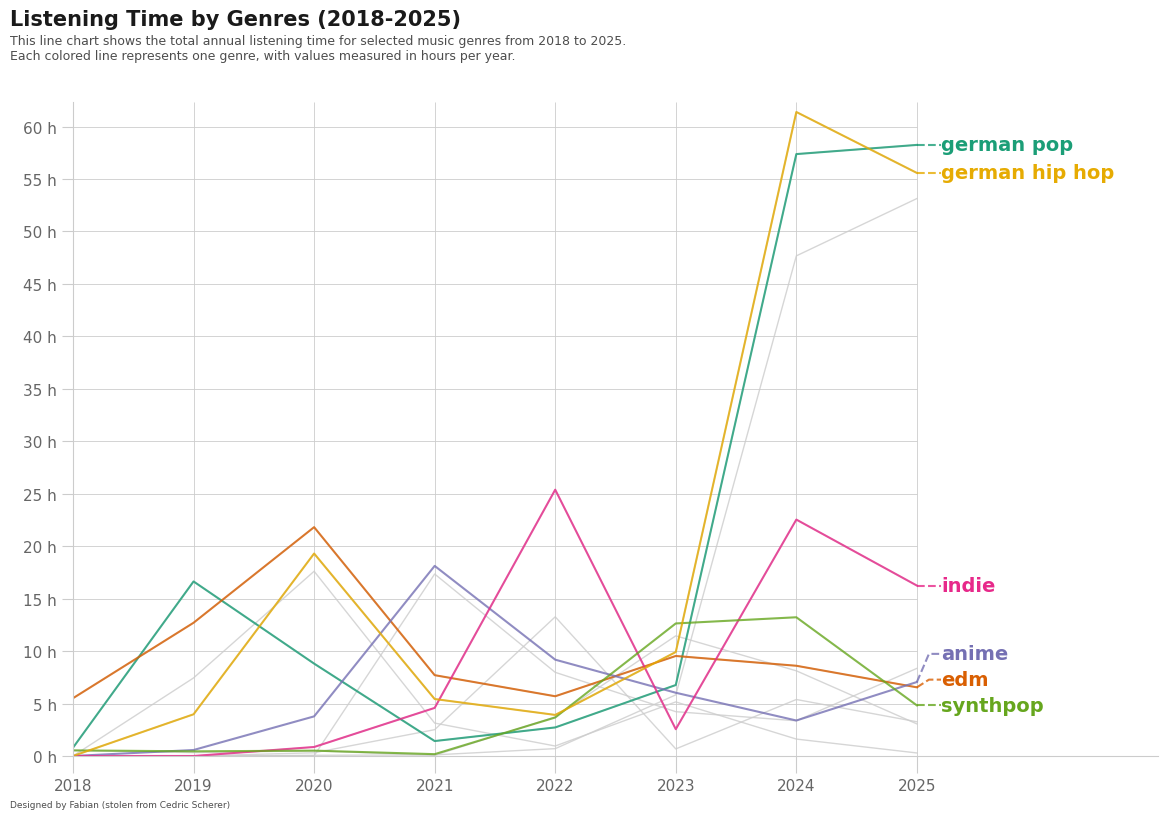

In [50]:
color_scheme = COLOR_SCALE_10

lst_y_max = []
for attr in df_top_attributes:
    lst_y_max.append(get_listening_dates_counted(attribute, [attr], measuring_value, start, end, format)[measuring_value].max())
for attr in df_mid_attributes:
    lst_y_max.append(get_listening_dates_counted(attribute, [attr], measuring_value, start, end, format)[measuring_value].max())
y_max = max(lst_y_max)

fig, ax = plt.subplots(figsize = (14, 8.5))

fig.patch.set_facecolor(GREY_SCALE[10])
ax.set_facecolor(GREY_SCALE[10])

ax.vlines(x=np.arange(start.year+1, end.year+1), ymin=0, ymax=y_max+1, color=GREY_SCALE[8], lw=0.6)
ax.hlines(y=np.arange(5 if measuring_value == "h_played" else 30, y_max, 5 if measuring_value == "h_played" else 30), xmin=start.year, xmax=end.year, color=GREY_SCALE[8], lw=0.6)

for idx, genre in enumerate(df_mid_attributes):
    x = get_listening_dates_counted(attribute, [genre], measuring_value, start, end, format)["date"]
    y = get_listening_dates_counted(attribute, [genre], measuring_value, start, end, format)[measuring_value]
    ax.plot(x, y, lw=1, alpha=0.8, color=GREY_SCALE[8])

for idx, genre in enumerate(df_top_attributes):
    x = get_listening_dates_counted(attribute, [genre], measuring_value, start, end, format)["date"]
    y = get_listening_dates_counted(attribute, [genre], measuring_value, start, end, format)[measuring_value]
    ax.plot(x, y, lw=1.5, alpha=0.8, color=color_scheme[idx])

label_position_y = enforce_tolerance([get_listening_dates_counted(attribute, [df_top_attributes.iloc[x]], measuring_value, start, end, format)[measuring_value].iloc[-1] for x in range(len(df_top_attributes))], tolerance=y_max/25)

for idx, genre in enumerate(df_top_attributes):
    color = color_scheme[idx]

    y_start = get_listening_dates_counted(attribute, [genre], measuring_value, start, end, format)[measuring_value].iloc[-1]
    y_end = label_position_y[idx]
    
    ax.plot(
        [end.year, end.year + 0.1, end.year + 0.2], 
        [y_start, y_end, y_end], 
        color=color, 
        alpha=0.8, 
        ls="dashed"
    )
    
    ax.text(
        end.year + 0.2, 
        y_end, 
        genre, 
        color=color, 
        fontsize=14, 
        weight="bold", 
        fontfamily="DejaVu Sans", 
        va="center"
    )

ax.set_xlim(start.year, 2027)
ax.set_ylim(0, y_max+1)

ax.set_yticks([y for y in np.arange(0, y_max, 5 if measuring_value == "h_played" else 30)])
ax.set_yticklabels([f"{y} {dict_time_disp[measuring_value]}" for y in np.arange(0, y_max, 5 if measuring_value == "h_played" else 30).astype(int)], fontname="DejaVu Sans", fontsize=11,color=GREY_SCALE[4])

ax.set_xticks([x for x in np.arange(start.year, end.year + 1)])
ax.set_xticklabels([x for x in np.arange(start.year, end.year + 1)], fontname= "DejaVu Sans", fontsize=11,color=GREY_SCALE[4])

ax.tick_params(axis="x", length=12, color=GREY_SCALE[8])
ax.tick_params(axis="y", length=8, color=GREY_SCALE[8])

ax.spines["left"].set_color(GREY_SCALE[8])
ax.spines["bottom"].set_color(GREY_SCALE[8])
ax.spines["right"].set_color("none")
ax.spines["top"].set_color("none")

fig.text(
    0.08,
    0.97,
    f"Listening Time by {dict_att_disp[attribute]}s ({start.year}-{end.year})",
    color=GREY_SCALE[1],
    fontsize=15,
    fontname="DejaVu Sans",
    weight="bold"
)

fig.text(
    0.08,
    0.93,
    f"\nThis line chart shows the total annual listening time for selected music {dict_att_disp[attribute].lower()}s from {start.year} to {end.year}.\nEach colored line represents one {dict_att_disp[attribute].lower()}, with values measured in {dict_att_disp[measuring_value].lower()} per {format}.",
    ha="left",
    color=GREY_SCALE[3],
    fontname="DejaVu Sans",
    fontsize=9,
)

fig.text(
    0.08, 
    0.05, 
    "Designed by Fabian (stolen from Cedric Scherer)", 
    fontname="DejaVu Sans", 
    fontsize=6.5, 
    color=GREY_SCALE[3], 
    ha="left"
)

plt.show()